# COMS-E6998-010: Homework 4
__Name:__ Nicholas Christman (n2677)   
__Due:__  Nov. 22, 2002


In [9]:
from __future__ import print_function, division

import sys
import time
import os
import copy
import numpy as np
import pandas
import matplotlib.pyplot as plt
import json
from pprint import pprint

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

# plt.ion()   # interactive mode

# set global seed
seed = 6998
torch.manual_seed(seed)

In [11]:
# use a GPU if there is one available
cuda_availability = torch.cuda.is_available()
if cuda_availability:
    device = torch.device('cuda:{}'.format(torch.cuda.current_device()))
else:
    device = 'cpu'
print('\n*************************')
print('GPU Available: {}'.format(cuda_availability))
print('Current Device: {}'.format(device))
print('*************************\n')
# display the GPU info
if cuda_availability:
    !nvidia-smi


*************************
GPU Available: True
Current Device: cuda:0
*************************

Sat Nov 14 06:49:01 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    30W /  70W |   1821MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+----------------------------------------------------------------------

# Problem 1 - Transfer learning: Shallow learning vs Finetuning, Pytorch (30)

Two major transfer learning scenarios are as follows:   
* Finetuning the base model: Instead of random initialization, we initialize the network with a pretrained network, like the one that is trained on Imagenet dataset. Rest of the training looks as usual however the learning rate schedule for transfer learning may be different.
* Base model as fixed feature extractor: Here, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.  

The following references were used to answer this problem:   
[1] Pytorch blog. Transfer Learning for Computer Vision Tutorial by S. Chilamkurthy   
&emsp; Available at https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html   
[2] Notes on Transfer Learning. CS231n Convolutional Neural Networks for Visual Recognition.   
&emsp; Available at https://cs231n.github.io/transfer-learning/   
[3] Visual Domain Decathlon (https://www.robots.ox.ac.uk/~vgg/decathlon/)   

In [7]:
# # to extract tar
# import tarfile
# tar = tarfile.open("data/ucf101.tar", 'r')
# tar.extractall()
# tar.close()

In [92]:
# hyperparameters
batch_size = 64
num_epochs = 5#200
momentum = 0.9
lr_init = 0.001
lr_decay = 0.1
lr_epochs = [np.floor(0.25*num_epochs),
              np.floor(0.50*num_epochs),
              np.floor(0.75*num_epochs)]


train_phases = ['train', 'val']

# Data augmentation and normalization for training
# Just normalization for validation and test
data_transforms = {
    'train': transforms.Compose([
#         transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# data_dir = 'data/dtd'
data_name = 'ucf101'
data_dir = os.path.join('data',data_name)

# the training & validation data
image_datasets = {}
dataloaders = {}
dataset_sizes = {}
for x in train_phases:
    image_datasets[x] = datasets.ImageFolder(os.path.join(data_dir, x), 
                                             data_transforms[x])

    dataloaders[x] = torch.utils.data.DataLoader(image_datasets[x], 
                                                 batch_size=batch_size,
                                                 shuffle=True, 
                                                 num_workers=4)
    
    dataset_sizes[x] = len(image_datasets[x])

# get some data info
class_names = image_datasets['train'].classes
num_classes = len(class_names)

print('Number of classes: {}'.format(num_classes))
for x in ['train', 'val']:
    print('Dataset \'{}\' size: {}'.format(x,dataset_sizes[x]))


# read in the annotations and get the actual class names
# ann_dir = 'data/dtd_ann'
ann_dir = os.path.join('data',data_name+'_ann')

# with open(os.path.join(ann_dir,'dtd_train.json')) as f:
with open(os.path.join(ann_dir,'ucf101_train.json')) as f:
    train_ann = json.load(f)
# extract the "class_names" (last 4 digits of category id) and actual names (class labels)
real_names = dict([ (str(cat['id'])[-4:], cat['name']) for cat in train_ann['categories'] ])
    
# Count the number of images per class
from collections import Counter
tmp = dict(Counter(image_datasets['train'].targets))
# for displaying, let's replace the class # with the actual class name
for k, v in real_names.items():
    tmp[v] = tmp[int(k)-1]
    del tmp[int(k)-1]
print('Number of images per class:')
print(tmp)

Number of classes: 101
Dataset 'train' size: 7585
Dataset 'val' size: 1952
Number of images per class:
{'ApplyEyeMakeup': 80, 'ApplyLipstick': 65, 'Archery': 83, 'BabyCrawling': 77, 'BalanceBeam': 61, 'BandMarching': 89, 'BaseballPitch': 85, 'Basketball': 79, 'BasketballDunk': 75, 'BenchPress': 89, 'Biking': 76, 'Billiards': 88, 'BlowDryHair': 74, 'BlowingCandles': 60, 'BodyWeightSquats': 65, 'Bowling': 89, 'BoxingPunchingBag': 91, 'BoxingSpeedBag': 77, 'BreastStroke': 58, 'BrushingTeeth': 76, 'CleanAndJerk': 63, 'CliffDiving': 79, 'CricketBowling': 82, 'CricketShot': 94, 'CuttingInKitchen': 61, 'Diving': 84, 'Drumming': 92, 'Fencing': 61, 'FieldHockeyPenalty': 68, 'FloorGymnastics': 71, 'FrisbeeCatch': 71, 'FrontCrawl': 80, 'GolfSwing': 80, 'Haircut': 77, 'HammerThrow': 85, 'Hammering': 84, 'HandstandPushups': 80, 'HandstandWalking': 61, 'HeadMassage': 84, 'HighJump': 68, 'HorseRace': 71, 'HorseRiding': 92, 'HulaHoop': 72, 'IceDancing': 89, 'JavelinThrow': 68, 'JugglingBalls': 64, 'Ju

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


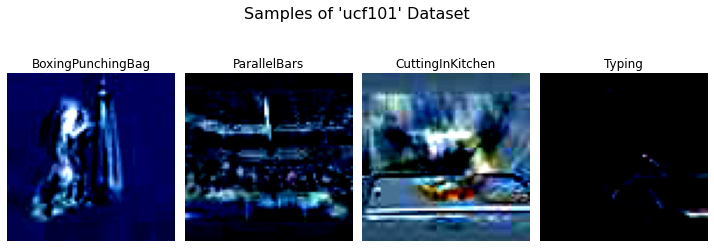

In [93]:
# function taken from the Pytorch tutorial [2]
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# select 4 unique classes to demo
uni, ind = np.unique(classes, return_index=True)
use = np.random.choice(ind, 4, replace=False)
# display samles
title = 'Samples of \'{}\' Dataset'.format(data_name)
fig = plt.figure(figsize=(10,4))
fig.suptitle(title, fontsize=16)
for i,u in enumerate(use):
    axn = fig.add_subplot(1, 4, i+1)
    axn.set_title(real_names[class_names[classes[u]]])
    axn.axis('off')
    axn.imshow(inputs[u].permute(1, 2, 0))     
plt.tight_layout(pad=1.0)
plt.show()

### 1(a) 
__Dataset Explanation:__  

For this problem I chose to use the [UCF101 - Action Recognition Dataset](https://www.crcv.ucf.edu/data/UCF101.php "ucf101 dataset"). According the the referenced website, the UCF101 dataset consists of "realistic action videos, collected from YouTube, having 101 action categories." As the descrption states, the UCF101 dataset has 101 classes representing different actions (e.g., longjump, headmassage, fencing, etc.). The data is split into training, validation, and test sets consiting of 7629, 1908, and 3783 images, respectively. The number of images per class is printed above as well 4 sample images from the dataset.   

*Note: The Visual Domain Decathlon dataset abstracted away the actual class names, so 4 extra lines of code (above) were implemened to grab the actual class names out of the annotations file.*

### 1(b)
Below we will load a pretrained Resnet50 model (using Pytorch)

In [138]:
phase_str = {'train': 'Training', 'val': 'Validating'}
def train_model(model, criterion, optimizer, scheduler, 
                num_epochs=25,gpu_check=False,verbose=0):
    since = time.time()
    
    print('Training model...')
    print('=' * 20)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    history = {'train': {
                        'time': [],
                        'loss': [],
                        'acc': [],
                        'best_acc': np.NaN
                    }, 
               'val': {
                       'time': [],
                       'loss': [],
                       'acc': [],
                       'best_acc': 0.0
                   }
              }
    for epoch in range(num_epochs):
        print('Epoch {}/{} (lr = {:.3e})'.format(epoch+1, num_epochs,
                                             optimizer.param_groups[0]['lr']))
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            phase_start = time.time()

            # use temp variable for brevity 
            epoch_hist = history[phase]

            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            num_iters = len(dataloaders[phase])
            iter_time = 0
            for iters, (inputs, labels) in enumerate(dataloaders[phase]):
                iter_start = time.time()
                # move data to "device" (i.e., GPU)
                inputs, labels = inputs.to(device), labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                iter_time += (time.time() - iter_start)
                if (iters % 10 == 0 or iters == num_iters) or verbose == 1:
                    loss_data = loss.item() 
                    print('\r{} [{}/{} ({:.0f}%)]   Time: {:.4f}   Loss: {:.4f}'.
                            format(phase_str[phase], 
                                   iters * len(inputs), 
                                   len(dataloaders[phase].dataset),
                                   100. * iters / len(dataloaders[phase]), 
                                   iter_time, loss_data), end='')
            # store some stats
            epoch_time = time.time() - phase_start


            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('\r{} [Done!]   Time: {:.4f}   Loss: {:.4f}   Acc: {:.4f}'.
                   format(phase_str[phase], epoch_time, 
                         epoch_loss, epoch_acc, end=''))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                epoch_hist['best_acc'] = best_acc.data.cpu().numpy().item()

            # store the history
            epoch_hist['time'].append(epoch_time)
            epoch_hist['loss'].append(epoch_loss)
            epoch_hist['acc'].append(epoch_acc.data.cpu().numpy().item())

        # for debug, check gpu performance
        if gpu_check:
            return model, history
       
        # console output        
        print('-' * 20)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, num_classes)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=lr_init, momentum=momentum)

# Decay learning rate per hyperparameters above
lr_scheduler_ft = torch.optim.lr_scheduler.MultiStepLR(optimizer_ft,
                                                      milestones=lr_epochs, 
                                                      gamma=lr_decay)#,
# lr_scheduler_ft.last_epoch = start_epoch - 1

model_ft, history = train_model(model_ft, criterion, optimizer_ft, lr_scheduler_ft,
                                   num_epochs=num_epochs,verbose=1)

Training model...
Epoch 1/5 (lr = 1.000e-03)
Training [2880/7585 (38%)]   Time: 5.5153   Loss: 4.4355

In [137]:
pprint(history['val'])

{'acc': [0.14754098360655737,
         0.17008196721311478,
         0.17264344262295084,
         0.1639344262295082,
         0.1762295081967213],
 'best_acc': 0.1762295081967213,
 'loss': [3.9731568117610743,
          3.8975930135758197,
          3.8824391716816384,
          3.885740882060567,
          3.8904357660012168],
 'time': [1.2508606910705566,
          1.252938985824585,
          1.2602357864379883,
          1.2670972347259521,
          1.294508934020996]}
